# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {YOUR NAMES}  
Summer Term 2024  

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Perceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [45]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchsummary


torch.manual_seed(42) # Set manual seed

In [46]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [47]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [48]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  

Files already downloaded and verified
Files already downloaded and verified


In [49]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

 

In [50]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    """ function to show a batch of images """
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12), ncols=4, nrows=4)
        for i in range(16):
            ax[i//4, i%4].imshow(images[i].permute(1, 2, 0))
            ax[i//4, i%4].set_title(f'Label: {labels[i]}')
            ax[i//4, i%4].axis('off')
        plt.show()
        break
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

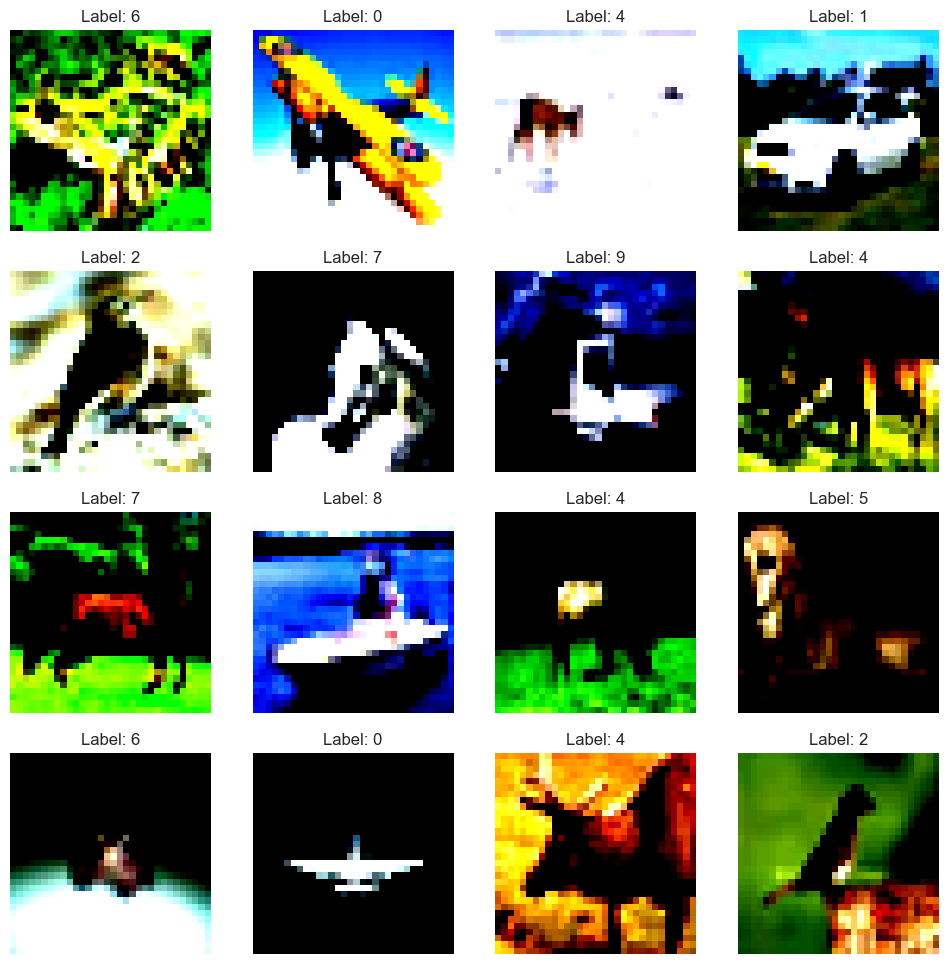

In [51]:
show_batch(train_loader)

In [52]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [53]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return  correct / total

In [54]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """

    model.to(device)
    model.train()
    t_loss = 0
    total_correct = 0
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss =  loss_fn(outputs, labels)  # Removed unsqueeze(-1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        master_bar.update()

    avg_loss = t_loss / len(dataloader)
    accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, accuracy
  


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    model.to(device)
    model.eval()
    v_loss = 0
    total_correct = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            v_loss += loss.item()
    
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            master_bar.update()
    
    avg_loss = v_loss / len(dataloader)
    accuracy = total_correct / len(dataloader.dataset)
    
    return avg_loss, accuracy
    

In [55]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in trange(num_epochs):
        master_bar = trange(len(train_dataloader), leave=False)
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        master_bar.close()
    return train_losses, val_losses, train_accs, val_accs
  
    
  

In [56]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    model.to(device)
    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes))
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                confusion_matrix[labels[i], predicted[i]] += 1
    return confusion_matrix

    

## Logistic Regression   

In [57]:
# TODO: define logistic regression model class and its necessary functions
# What are the dimensions of your input layer?
# TODO: flatten the input to a suitable size for the initial layer


class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out




In [58]:
## TODO : Define network, put it to the device and train mode
logistic_regression = LogisticRegression(3072, num_classes).to(device)

In [59]:
## Optimizer defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)

In [60]:
## Optimizer defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [61]:
# TODO: define the loss function
loss_function = nn.CrossEntropyLoss()

In [62]:
num_epochs = 20
## TODO: run training over 20 epochs
LO_train_losses, LO_val_losses, LO_train_accs, LO_val_accs = run_training(logistic_regression, optimizer, loss_function, device, num_epochs, train_loader, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 2/196 [00:00<00:11, 17.31it/s]

  3%|▎         | 5/196 [00:00<00:08, 22.64it/s]

  4%|▍         | 8/196 [00:00<00:07, 24.56it/s]

  6%|▌         | 11/196 [00:00<00:07, 25.17it/s]

  7%|▋         | 14/196 [00:00<00:07, 25.54it/s]

  9%|▊         | 17/196 [00:00<00:07, 25.16it/s]

 10%|█         | 20/196 [00:00<00:06, 25.28it/s]

 12%|█▏        | 23/196 [00:00<00:06, 25.78it/s]

 13%|█▎        | 26/196 [00:01<00:06, 26.18it/s]

 15%|█▍        | 29/196 [00:01<00:06, 25.48it/s]

 16%|█▋        | 32/196 [00:01<00:06, 25.04it/s]

 18%|█▊        | 35/196 [00:01<00:06, 24.87it/s]

 19%|█▉        | 38/196 [00:01<00:06, 25.13it/s]

 21%|██        | 41/196 [00:01<00:06, 25.44it/s]

 22%|██▏       | 44/196 [00:01<00:05, 25.69it/s]

 24%|██▍       | 47/196 [00:01<00:05, 25.90it/s]

 26%|██▌       | 50/196 [00:01<00:05, 26.38it/s]

 27%|██▋       | 53/196 [00:02<00:05, 26.56it/s]

 29%|██▊       | 56/19

## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

. A nonlinear neural network can learn nonlinear patterns and features in the data, and it can model complex and high-dimensional problems.

In [63]:
## TODO: Make the 4 layer MLP  with the following shapes :
## input_dim -> 2048 -> 512 -> 128 -> output_dim
## Use RELu as nonlinearity
## In the forward pass do not forget to flatten the input
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [64]:
## TODO: Define network, put it to device and train mode
mlp = MLP(3072, num_classes).to(device)

In [65]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [66]:
## TODO: Train the MLP over 20 epochs
MLP_train_losses, MLP_val_losses, MLP_train_accs, MLP_val_accs = run_training(mlp, optimizer, loss_function, device, num_epochs, train_loader, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:30,  6.35it/s]

  1%|          | 2/196 [00:00<00:26,  7.43it/s]

  2%|▏         | 3/196 [00:00<00:23,  8.09it/s]

  2%|▏         | 4/196 [00:00<00:22,  8.36it/s]

  3%|▎         | 6/196 [00:00<00:17, 10.94it/s]

  4%|▍         | 8/196 [00:00<00:18, 10.01it/s]

  5%|▌         | 10/196 [00:00<00:16, 11.39it/s]

  6%|▌         | 12/196 [00:01<00:15, 11.65it/s]

  7%|▋         | 14/196 [00:01<00:15, 11.89it/s]

  8%|▊         | 16/196 [00:01<00:14, 12.26it/s]

  9%|▉         | 18/196 [00:01<00:14, 12.23it/s]

 10%|█         | 20/196 [00:01<00:14, 12.40it/s]

 11%|█         | 22/196 [00:01<00:13, 12.76it/s]

 13%|█▎        | 25/196 [00:02<00:11, 15.13it/s]

 14%|█▍        | 28/196 [00:02<00:10, 16.78it/s]

 16%|█▌        | 31/196 [00:02<00:09, 18.12it/s]

 17%|█▋        | 34/196 [00:02<00:08, 19.07it/s]

 18%|█▊        | 36/196 [00:02<00:08, 19.20it/s]

 19%|█▉        | 38/196 [

## Add L2 regularisation

In [67]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.00005 is a good starting point for the regularization strength
## You can use the weight_decay parameter in the optimizer to apply L2 regularization
mlp = MLP(3072, num_classes).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.00005)
loss_function = nn.CrossEntropyLoss()

In [68]:
## TODO: Retrain new model with regularization over 20 epochs
l2_train_losses, l2_val_losses, l2_train_accs, l2_val_accs = run_training(mlp, optimizer, loss_function, device, num_epochs, train_loader, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 2/196 [00:00<00:12, 15.98it/s]

  3%|▎         | 5/196 [00:00<00:10, 18.91it/s]

  4%|▍         | 8/196 [00:00<00:09, 19.84it/s]

  6%|▌         | 11/196 [00:00<00:09, 20.49it/s]

  7%|▋         | 14/196 [00:00<00:08, 20.56it/s]

  9%|▊         | 17/196 [00:00<00:08, 20.38it/s]

 10%|█         | 20/196 [00:00<00:08, 20.62it/s]

 12%|█▏        | 23/196 [00:01<00:08, 20.64it/s]

 13%|█▎        | 26/196 [00:01<00:08, 20.64it/s]

 15%|█▍        | 29/196 [00:01<00:08, 20.62it/s]

 16%|█▋        | 32/196 [00:01<00:07, 20.67it/s]

 18%|█▊        | 35/196 [00:01<00:07, 21.00it/s]

 19%|█▉        | 38/196 [00:01<00:07, 20.80it/s]

 21%|██        | 41/196 [00:01<00:07, 21.01it/s]

 22%|██▏       | 44/196 [00:02<00:07, 21.08it/s]

 24%|██▍       | 47/196 [00:02<00:06, 21.33it/s]

 26%|██▌       | 50/196 [00:02<00:06, 21.14it/s]

 27%|██▋       | 53/196 [00:02<00:06, 20.73it/s]

 29%|██▊       | 56/19

## LeNet5

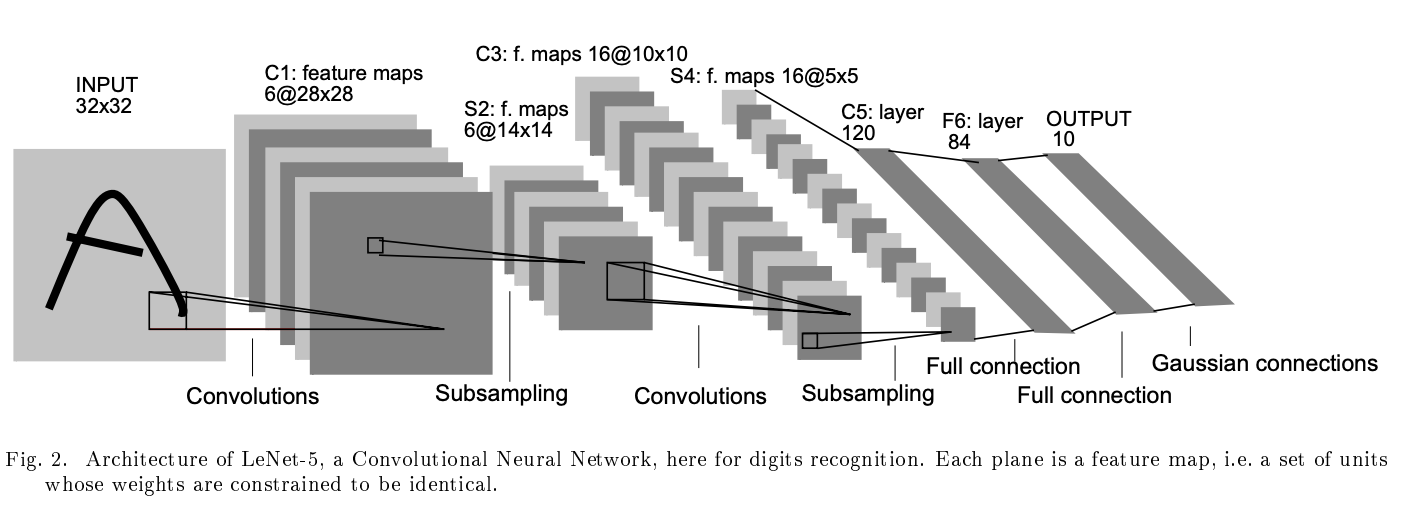

Let's implememt one of the classical convolutional network and apply it for CIFAR-10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implementation of LeNet5 has Tanh as nonlinearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [69]:
class LeNet5(nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)  # flatten the tensor
        logits = self.classifier(x)
        return logits

In [70]:
# TODO: define network, put it to the device and train model
net=LeNet5(n_classes=10, in_channels=3).to(device)
net.train()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

For a quick overview of models, torchsummary.summary is quite helpful  
comment: You can also import predefined architectures from `torchvision` and run `torchsummary.summary` on them to get a quick overview

In [71]:
## TODO: run torchsummary.summary on the LeNet5 and your MLP model. What do you see?

torchsummary.summary(net, (3, 32, 32))
torchsummary.summary(mlp, (3072,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              ReLU-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [72]:
## TODO: define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [73]:
## TODO: train with 20 epochs
num_epochs = 20
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = run_training(net, optimizer, loss_function, device, num_epochs, train_loader, test_loader)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 2/196 [00:00<00:15, 12.13it/s]

  2%|▏         | 4/196 [00:00<00:14, 13.43it/s]

  3%|▎         | 6/196 [00:00<00:13, 14.01it/s]

  4%|▍         | 8/196 [00:00<00:13, 14.18it/s]

  5%|▌         | 10/196 [00:00<00:13, 14.13it/s]

  6%|▌         | 12/196 [00:00<00:13, 13.91it/s]

  7%|▋         | 14/196 [00:01<00:13, 13.54it/s]

  8%|▊         | 16/196 [00:01<00:13, 13.55it/s]

  9%|▉         | 18/196 [00:01<00:13, 13.47it/s]

 10%|█         | 20/196 [00:01<00:13, 13.40it/s]

 11%|█         | 22/196 [00:01<00:12, 13.49it/s]

 12%|█▏        | 24/196 [00:01<00:12, 13.40it/s]

 13%|█▎        | 26/196 [00:01<00:12, 13.35it/s]

 14%|█▍        | 28/196 [00:02<00:12, 13.34it/s]

 15%|█▌        | 30/196 [00:02<00:12, 13.43it/s]

 16%|█▋        | 32/196 [00:02<00:12, 13.41it/s]

 17%|█▋        | 34/196 [00:02<00:12, 13.22it/s]

 18%|█▊        | 36/196 [00:02<00:12, 12.55it/s]

 19%|█▉        | 38/196

## Analysis 

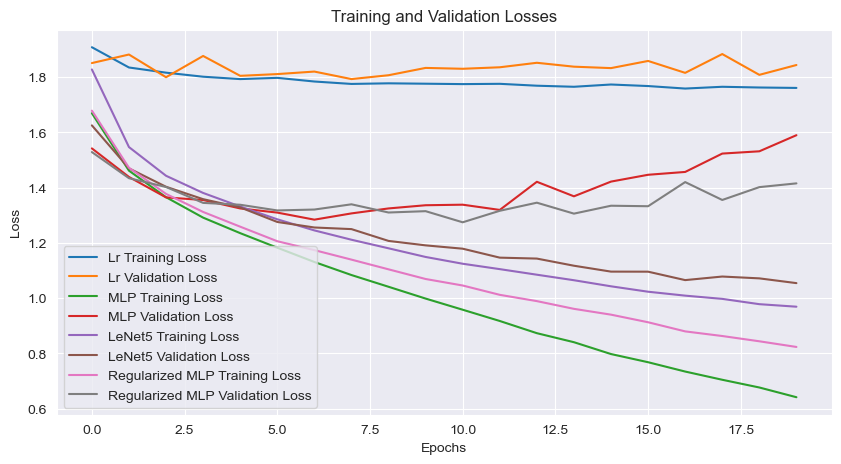

In [74]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

plt.figure(figsize=(10,5))
plt.title("Training and Validation Losses")
plt.plot(LO_train_losses, label="Lr Training Loss")
plt.plot(LO_val_losses, label="Lr Validation Loss")
plt.plot(MLP_train_losses, label="MLP Training Loss")
plt.plot(MLP_val_losses, label="MLP Validation Loss")
plt.plot(cnn_train_losses, label="LeNet5 Training Loss")
plt.plot(cnn_val_losses, label="LeNet5 Validation Loss")
plt.plot(l2_train_losses, label="Regularized MLP Training Loss")
plt.plot(l2_val_losses, label="Regularized MLP Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



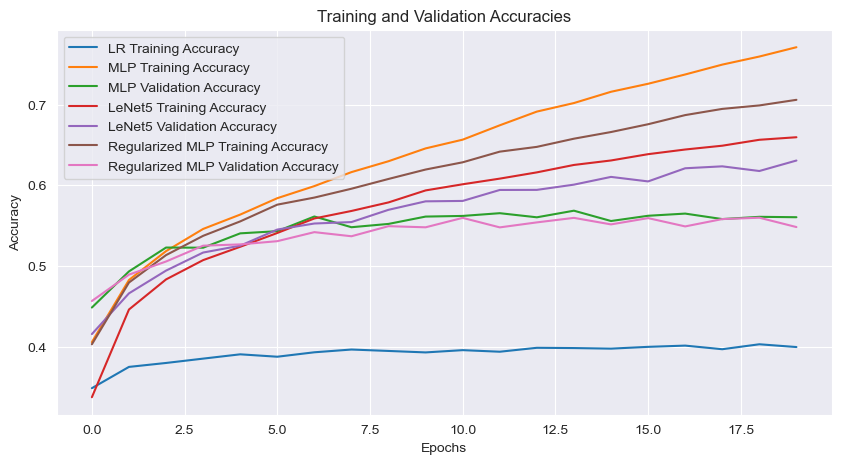

In [80]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?


plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracies")
plt.plot(LO_train_accs, label="LR Training Accuracy")
plt.plot(MLP_train_accs, label="MLP Training Accuracy")
plt.plot(MLP_val_accs, label="MLP Validation Accuracy")
plt.plot(cnn_train_accs, label="LeNet5 Training Accuracy")
plt.plot(cnn_val_accs, label="LeNet5 Validation Accuracy")
plt.plot(l2_train_accs, label="Regularized MLP Training Accuracy")
plt.plot(l2_val_accs, label="Regularized MLP Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

ValueError: Unknown format code 'd' for object of type 'float'

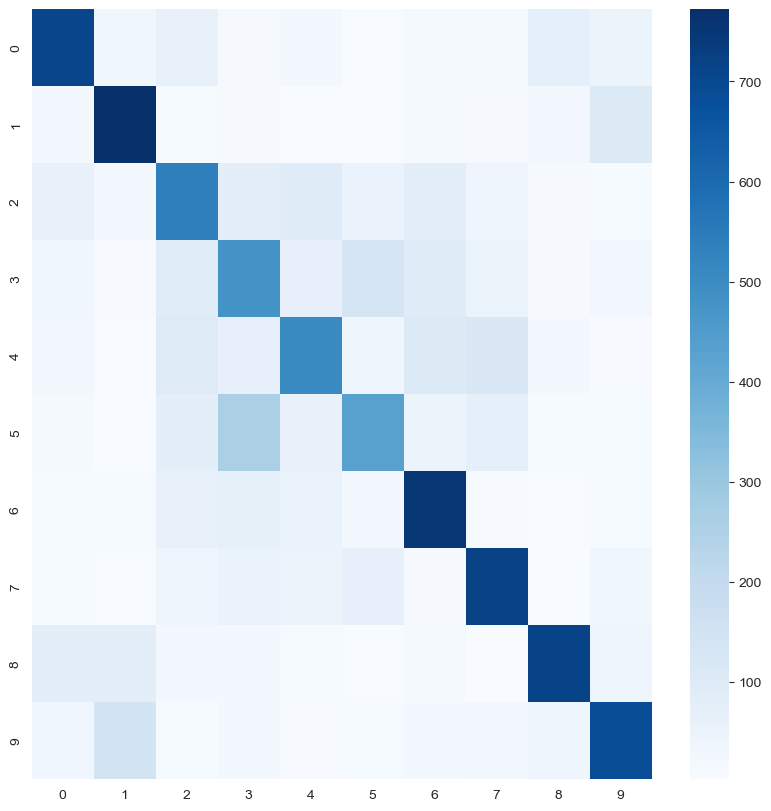

In [79]:
## TODO: Plot the confusion matrix for LeNet5
net.eval()  # set the model to evaluation mode
predictions = []
true_labels = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Plot confusion matrix
import seaborn as sns
confusion_matrix = calc_confusion_values(test_loader, net, device)
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for LeNet5')
plt.show()

## Questions
How did regularization change the performance of the MLP? Why?
It overfit less thanks to the regolarization term

Explain the confusion matrix for LeNet5. What do you see there?
on the y axis we have the actual label on the x the predictions. The diagonal is the correct predictions, the off diagonal are the misclassifications
The confusion matrix shows that while LeNet-5 is effective in classifying many images correctly in the CIFAR-10 dataset, there are specific areas where it struggles, as indicated by the off-diagonal misclassifications. 


Explain the difference in performance between linear regression, MLP, and LeNet5.
the linear model is to shallow to interpret the data, the MLP is more complex and can capture more complex patterns but has a lot of parameters so it's more heavy and overfits , the LeNet5 is a convolutional network that is better suited for image classification tasks

Why are convolutions better suited for pictures? Which properties of images do they exploit?
Convolutions are better suited for pictures because they effectively capture spatial hierarchies in images by preserving the spatial relationships between pixels. They exploit properties such as local pattern, allowing for the detection of features regardless of their position in the image. Additionally, convolutions reduce the number of parameters compared to fully connected layers, making the model more efficient and less prone to overfitting.


Is it important to redefine an optimizer for each different model, training? What about loss functions?
Yes, it is important to redefine optimizers and loss functions for each model to achieve better results. For example, CNNs typically perform well with optimizers like Adam and loss functions like cross-entropy for classification tasks, while MLPs may benefit from similar settings but need tuning based on their depth and complexity. Logistic Regression (LR), being simpler, might work well with gradient descent optimizers and binary cross-entropy for binary classification tasks.

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
